In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tfrecorder import TFrecorder
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


# input_fn's

In [2]:
tfr = TFrecorder()
def input_fn_maker(path, data_info_path, shuffle=False, batch_size = 1, epoch = 1, padding = None):
    def input_fn():
        filenames = tfr.get_filenames(path=path, shuffle=shuffle)
        dataset=tfr.get_dataset(paths=filenames, data_info=data_info_path, shuffle = shuffle, 
                            batch_size = batch_size, epoch = epoch, padding =padding)
        iterator = dataset.make_one_shot_iterator()
        return iterator.get_next()
    return input_fn

padding_info = ({'image':[28,28,1],'label':[]})
test_input_fn = input_fn_maker('mnist_tfrecord/test/',  'mnist_tfrecord/data_info.csv',batch_size = 512,
                               padding = padding_info)
train_input_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', shuffle=True, batch_size = 128,
                               padding = padding_info)
train_eval_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', batch_size = 512,
                               padding = padding_info)

# model

In [3]:
def model_fn(features, mode):
    # shape: [None,28,28,1]
    conv1 = tf.layers.conv2d(
        inputs=features['image'],
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu,
        name = 'conv1')
    # shape: [None,28,28,32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2, name= 'pool1')
    # shape: [None,14,14,32]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu,
        name = 'conv2')
    # shape: [None,14,14,64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2, name= 'pool2')
    # shape: [None,7,7,64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64], name= 'pool2_flat')
    # shape: [None,3136]
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name= 'dense1')
    # shape: [None,1024]
    dropout = tf.layers.dropout(inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # shape: [None,1024]
    logits = tf.layers.dense(inputs=dropout, units=10, name= 'output')
    # shape: [None,10]
    predictions = {
        "image":features['image'],
        "conv1_out":conv1,
        "pool1_out":pool1,
        "conv2_out":conv2,
        "pool2_out":pool2,
        "pool2_flat_out":pool2_flat,
        "dense1_out":dense1,
        "logits":logits,
        "classes": tf.argmax(input=logits, axis=1),
        "labels": features['label'],
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=features['label'], logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=features['label'], predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# logging

In [5]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

# create estimator

In [6]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_fn, model_dir="mnist_model_cnn")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_model_cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f98d4568128>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# train

In [7]:
mnist_classifier.train(
    input_fn=train_input_fn,
    hooks=[logging_hook])

read dataframe from mnist_tfrecord/data_info.csv
   default  isbyte length_type   name  shape     type
0      NaN   False       fixed  image  [784]  float32
1      NaN   False       fixed  label     []    int64
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into mnist_model_cnn/model.ckpt.
INFO:tensorflow:probabilities = [[0.10735776 0.09836856 0.09497292 ... 0.09814235 0.10779435 0.09586911]
 [0.10370693 0.104123   0.10526982 ... 0.10487434 0.10437662 0.0980461 ]
 [0.10544962 0.09448729 0.08993494 ... 0.09715178 0.11094446 0.10261528]
 ...
 [0.11204325 0.10005334 0.0944635  ... 0.08840991 0.1041621  0.11087643]
 [0.10223292 0.09257616 0.0945285  ... 0.09397934 0.11045069 0.10631656]
 [0.10971629 0.09682897 0.09939873 ... 0.10562865 0.09889013 0.09752256]]
INFO:tensorflow:loss = 2.302704, step = 1
INFO:tensorflow:probabilities = [[0.00001527 0.9990571  0.00022797 ... 0.00039954 0.00004374 0.0000326 ]
 [0.82890403 0.00000193 0.0189919  ... 0.0068629

# evaluate train set 

In [8]:
eval_results = mnist_classifier.evaluate(input_fn=train_eval_fn)
print('train set')
print(eval_results)

read dataframe from mnist_tfrecord/data_info.csv
   default  isbyte length_type   name  shape     type
0      NaN   False       fixed  image  [784]  float32
1      NaN   False       fixed  label     []    int64
INFO:tensorflow:Starting evaluation at 2018-02-08-08:11:59
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-430
INFO:tensorflow:Finished evaluation at 2018-02-08-08:12:05
INFO:tensorflow:Saving dict for global step 430: accuracy = 0.9870727, global_step = 430, loss = 0.041405413
train set
{'accuracy': 0.9870727, 'loss': 0.041405413, 'global_step': 430}


# evaluate test set 

In [9]:
eval_results = mnist_classifier.evaluate(input_fn=test_input_fn)
print('test set')
print(eval_results)

read dataframe from mnist_tfrecord/data_info.csv
   default  isbyte length_type   name  shape     type
0      NaN   False       fixed  image  [784]  float32
1      NaN   False       fixed  label     []    int64
INFO:tensorflow:Starting evaluation at 2018-02-08-08:12:11
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-430
INFO:tensorflow:Finished evaluation at 2018-02-08-08:12:13
INFO:tensorflow:Saving dict for global step 430: accuracy = 0.9873, global_step = 430, loss = 0.037189495
test set
{'accuracy': 0.9873, 'loss': 0.037189495, 'global_step': 430}


# predict

In [10]:
predicts =list(mnist_classifier.predict(input_fn=test_input_fn))

read dataframe from mnist_tfrecord/data_info.csv
   default  isbyte length_type   name  shape     type
0      NaN   False       fixed  image  [784]  float32
1      NaN   False       fixed  label     []    int64
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-430


# print predictions

In [11]:
predicts[0].keys()

dict_keys(['image', 'conv1_out', 'pool1_out', 'conv2_out', 'pool2_out', 'pool2_flat_out', 'dense1_out', 'logits', 'classes', 'labels', 'probabilities'])

In [12]:
predicts[0]['image'].shape

(28, 28, 1)

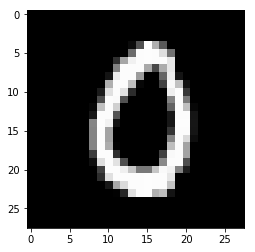

In [13]:
plt.imshow(predicts[0]['image'][:,:,0],cmap = plt.cm.gray)

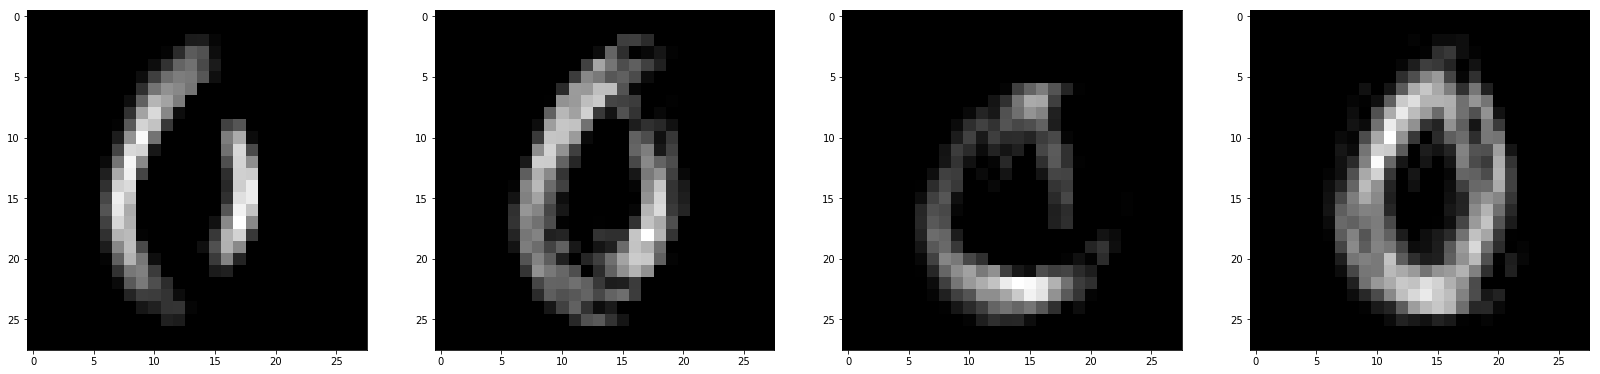

In [14]:
plt.figure(num=4,figsize=(28,28))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(predicts[0]['conv1_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('conv1_out.png')

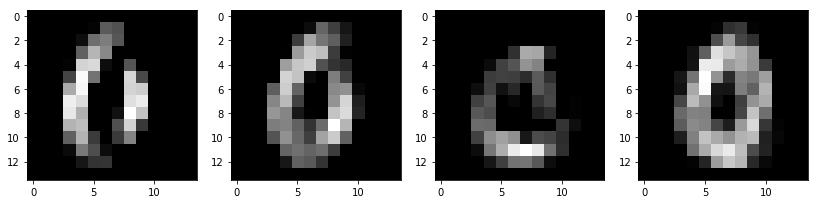

In [15]:
plt.figure(num=4,figsize=(14,14))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(predicts[0]['pool1_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('pool1_out.png')

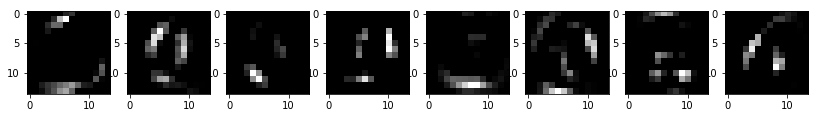

In [16]:
plt.figure(num=8,figsize=(14,14))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(predicts[0]['conv2_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('conv2_out.png')

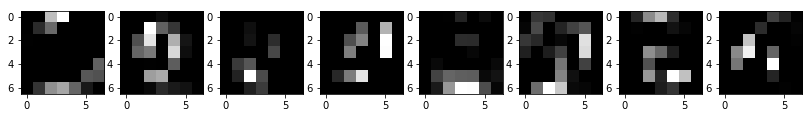

In [17]:
plt.figure(num=8,figsize=(14,14))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(predicts[0]['pool2_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('pool2_out.png')